# Part-of-Speech Tagging using Feedforward Networks and Embeddings

Author: Pierre Nugues

A part-of-speech tagger using feed-forward networks and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

## Python Headers

### The Modules

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Some Parameters

In [2]:
SIMPLE_MODEL = False
BATCH_SIZE = 128
EPOCHS = 4
MINI_CORPUS = False
EMB_LARGE = True

In [3]:
random.seed(1234)
torch.manual_seed(1234)

## Preprocessing

### GloVe

In [4]:
if EMB_LARGE:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.50d.txt'
    EMBEDDING_DIM = 50

In [5]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = torch.FloatTensor(list(map(float, values[1:])))
        embeddings[word] = vector
    glove.close()
    return embeddings

In [6]:
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

### Loading the Corpus

In [7]:
def load_ud_en_ewt():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/ud-treebanks-v2.9/UD_English-EWT/'
    train_file = BASE_DIR + 'en_ewt-ud-train.conllu'
    dev_file = BASE_DIR + 'en_ewt-ud-dev.conllu'
    test_file = BASE_DIR + 'en_ewt-ud-test.conllu'
    column_names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 
                    'FEATS', 'HEAD', 'DEPREL', 'HEAD', 'DEPS', 'MISC']
    column_names = list(map(str.lower, column_names))
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

def load_conll2009_pos():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/conll2009/en/'
    train_file = BASE_DIR + 'CoNLL2009-ST-English-train-pos.txt'
    dev_file = BASE_DIR + 'CoNLL2009-ST-English-development-pos.txt'
    test_file = BASE_DIR + 'CoNLL2009-ST-test-words-pos.txt'
    # test2_file = 'simple_pos_test.txt'

    column_names = ['id', 'form', 'lemma', 'plemma', 'pos', 'ppos']

    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# train_sentences, dev_sentences, test_sentences, column_names = \
# load_conll2009_pos()
train_sentences, dev_sentences, test_sentences, column_names =\
load_ud_en_ewt()
train_sentences[:350]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001\n# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001\n# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town o'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [8]:
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [9]:
conll_dict = CoNLLDictorizer(column_names, col_sep='\t')

train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'id': '1', 'form': 'Al', 'lemma': 'Al', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '0:root', 'deprel': 'root', 'deps': 'SpaceAfter=No'}, {'id': '2', 'form': '-', 'lemma': '-', 'upos': 'PUNCT', 'xpos': 'HYPH', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': 'SpaceAfter=No'}, {'id': '3', 'form': 'Zaman', 'lemma': 'Zaman', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '1:flat', 'deprel': 'flat', 'deps': '_'}, {'id': '4', 'form': ':', 'lemma': ':', 'upos': 'PUNCT', 'xpos': ':', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': '_'}, {'id': '5', 'form': 'American', 'lemma': 'American', 'upos': 'ADJ', 'xpos': 'JJ', 'feats': 'Degree=Pos', 'head': '6:amod', 'deprel': 'amod', 'deps': '_'}, {'id': '6', 'form': 'forces', 'lemma': 'force', 'upos': 'NOUN', 'xpos': 'NNS', 'feats': 'Number=Plur', 'head': '7:nsubj', 'deprel': 'nsubj', 'deps': '_'}, {'id': '7', 'form': 'killed', 'lemma': 'kill', 'upos': 'VERB', 'xpos'

### Extracting the Context and Dictorizing it
We extract windows of five words surrounding the word

In [10]:
class ContextDictorizer():
    """
    Extract contexts of words in a sequence
    Contexts are of w_size to the left and to the right
    Builds an X matrix in the form of a dictionary
    and possibly extracts the output, y, if not in the test step
    If the test_step is True, returns y = []
    """

    def __init__(self, input='form', output='upos', w_size=2, tolower=True):
        self.BOS_symbol = '__BOS__'
        self.EOS_symbol = '__EOS__'
        self.input = input
        self.output = output
        self.w_size = w_size
        self.tolower = tolower
        # This was not correct as the names were not sorted
        # self.feature_names = [input + '_' + str(i)
        #                     for i in range(-w_size, w_size + 1)]
        # To be sure the names are ordered
        zeros = math.ceil(math.log10(2 * w_size + 1))
        self.feature_names = [input + '_' + str(i).zfill(zeros) for 
                              i in range(2 * w_size + 1)]

    def fit(self, sentences):
        """
        Build the padding rows
        :param sentences:
        :return:
        """
        self.column_names = sentences[0][0].keys()
        start = [self.BOS_symbol] * len(self.column_names)
        end = [self.EOS_symbol] * len(self.column_names)
        start_token = Token(dict(zip(self.column_names, start)))
        end_token = Token(dict(zip(self.column_names, end)))
        self.start_rows = [start_token] * self.w_size
        self.end_rows = [end_token] * self.w_size

    def transform(self, sentences, training_step=True):
        X_corpus = []
        y_corpus = []
        for sentence in sentences:
            X, y = self._transform_sentence(sentence, training_step)
            X_corpus += X
            if training_step:
                y_corpus += y
        return X_corpus, y_corpus

    def fit_transform(self, sentences):
        self.fit(sentences)
        return self.transform(sentences)

    def _transform_sentence(self, sentence, training_step=True):
        # We extract y
        if training_step:
            y = [row[self.output] for row in sentence]
        else:
            y = None

        # We pad the sentence
        sentence = self.start_rows + sentence + self.end_rows

        # We extract the features
        X = list()
        for i in range(len(sentence) - 2 * self.w_size):
            # x is a row of X
            x = list()
            # The words in lower case
            for j in range(2 * self.w_size + 1):
                if self.tolower:
                    x.append(sentence[i + j][self.input].lower())
                else:
                    x.append(sentence[i + j][self.input])
            # We represent the feature vector as a dictionary
            X.append(dict(zip(self.feature_names, x)))
        return X, y

    def print_example(self, sentences, id=1968):
        """
        :param corpus:
        :param id:
        :return:
        """
        # We print the features to check they match Table 8.1 in my book (second edition)
        # We use the training step extraction with the dynamic features
        Xs, ys = self._transform_sentence(sentences[id])
        print('X for sentence #', id, Xs)
        print('y for sentence #', id, ys)

### Running the Feature Extraction

In [11]:
context_dictorizer = ContextDictorizer()
context_dictorizer.fit(train_dict)
X_train_dict, y_train_cat = context_dictorizer.transform(train_dict)
X_val_dict, y_val_cat = context_dictorizer.transform(dev_dict)

In [12]:
context_dictorizer.print_example(train_dict)

X for sentence # 1968 [{'form_0': '__bos__', 'form_1': '__bos__', 'form_2': 'do', 'form_3': 'we', 'form_4': 'intend'}, {'form_0': '__bos__', 'form_1': 'do', 'form_2': 'we', 'form_3': 'intend', 'form_4': 'to'}, {'form_0': 'do', 'form_1': 'we', 'form_2': 'intend', 'form_3': 'to', 'form_4': 'reference'}, {'form_0': 'we', 'form_1': 'intend', 'form_2': 'to', 'form_3': 'reference', 'form_4': 'a'}, {'form_0': 'intend', 'form_1': 'to', 'form_2': 'reference', 'form_3': 'a', 'form_4': 'particular'}, {'form_0': 'to', 'form_1': 'reference', 'form_2': 'a', 'form_3': 'particular', 'form_4': 'manufacturer'}, {'form_0': 'reference', 'form_1': 'a', 'form_2': 'particular', 'form_3': 'manufacturer', 'form_4': ','}, {'form_0': 'a', 'form_1': 'particular', 'form_2': 'manufacturer', 'form_3': ',', 'form_4': 'or'}, {'form_0': 'particular', 'form_1': 'manufacturer', 'form_2': ',', 'form_3': 'or', 'form_4': 'should'}, {'form_0': 'manufacturer', 'form_1': ',', 'form_2': 'or', 'form_3': 'should', 'form_4': 'this

We extract all the words

In [13]:
corpus_words = []
for x in X_train_dict:
    corpus_words.extend(x.values())
corpus_words = sorted(set(corpus_words))
print('# unique words seen in training corpus:', len(corpus_words))

# unique words seen in training corpus: 17116


In [14]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary_words = set(corpus_words + list(embeddings_words))
cnt_uniq = len(vocabulary_words) + 1
print('# unique words in the vocabulary: embeddings and corpus:', 
      cnt_uniq)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402012


In [15]:
idx2word = dict(enumerate(sorted(vocabulary_words), start=1))
word2idx = {v: k for k, v in idx2word.items()}

In [16]:
for x_train_dict in X_train_dict:
    for word in x_train_dict:
        x_train_dict[word] = word2idx[x_train_dict[word]]

for x_val_dict in X_val_dict:
    for word in x_val_dict:
        x_val_dict[word] = word2idx.get(x_val_dict[word], 0)

### Vectorizing the ${X}$ Matrix

In [17]:
dict_vect = DictVectorizer(dtype=np.float32, sparse=False)
X_train = dict_vect.fit_transform(X_train_dict)
X_val = dict_vect.transform(X_val_dict)

In [18]:
X_train.shape

(207229, 5)

In [19]:
X_train[0]

array([ 43517.,  43517.,  50471.,    654., 397777.], dtype=float32)

### Vectorizing the ${X}$ Matrix

In [20]:
# We transform the X symbols into numbers
dict_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
X_train_num = dict_vectorizer.fit_transform(X_train_dict)
X_val_num = dict_vectorizer.transform(X_val_dict)

### Vectorizing $\mathbf{y}$

We create a torch matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

We initialize the matrix with random values with the `torch.rand()`

In [21]:
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))/10 - 0.05 # range: -0.05, 0.05, 
# embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = torch.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

The shape of the matrix is: (411326, 100) or (411326, 50)

In [22]:
embedding_matrix.shape

torch.Size([402013, 100])

We fill the matrix with the GloVe embeddings when available. This means: We replace the random vector with an embedding when available. We will use the indices from the previous section. We call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [23]:
out_of_embeddings = []
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]
    else:
        # Otherwise, it keeps a random value in the matrix
        # We store the out of vocabulary words
        out_of_embeddings += [word]

In [24]:
len(out_of_embeddings)

2011

In [25]:
out_of_embeddings[-10:]

['intra-day',
 "to's",
 'i/s',
 "de'",
 'http://dianacamera.com',
 "coordinator's",
 'mailto:mayur...@yahoo.com',
 'http://www.cruisecompete.com/specials/regions/world/1',
 "they'll",
 'squirelled']

Embeddings of the padding symbol, idx 0, random numbers

In [26]:
embedding_matrix[0][:10]

tensor([-0.0471, -0.0098, -0.0240, -0.0133, -0.0442,  0.0201, -0.0448, -0.0032,
         0.0174, -0.0169])

Embeddings of the word _table_, the GloVe values

In [27]:
embedding_matrix[word2idx['table']][:10]

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215])

Embeddings of _äänekoski_, a word in IMDB, but not in GloVe, random numbers

In [28]:
embedding_matrix[word2idx['saucey']][:10]

tensor([ 0.0153,  0.0269, -0.0061,  0.0112, -0.0378,  0.0126,  0.0018, -0.0081,
         0.0370, -0.0275])

The POS and the number of different POS

In [29]:
pos_list = sorted(set(y_train_cat))
NB_CLASSES = len(pos_list) + 1
pos_list

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '_']

We build a part-of-speech index. We keep 0 for unknown symbols in the test set

In [30]:
idx2pos = dict(enumerate(pos_list, start=1))
pos_idx = {v: k for k, v in idx2pos.items()}
print(idx2pos)
pos_idx

{1: 'ADJ', 2: 'ADP', 3: 'ADV', 4: 'AUX', 5: 'CCONJ', 6: 'DET', 7: 'INTJ', 8: 'NOUN', 9: 'NUM', 10: 'PART', 11: 'PRON', 12: 'PROPN', 13: 'PUNCT', 14: 'SCONJ', 15: 'SYM', 16: 'VERB', 17: 'X', 18: '_'}


{'ADJ': 1,
 'ADP': 2,
 'ADV': 3,
 'AUX': 4,
 'CCONJ': 5,
 'DET': 6,
 'INTJ': 7,
 'NOUN': 8,
 'NUM': 9,
 'PART': 10,
 'PRON': 11,
 'PROPN': 12,
 'PUNCT': 13,
 'SCONJ': 14,
 'SYM': 15,
 'VERB': 16,
 'X': 17,
 '_': 18}

We encode $\mathbf{y}$. We use one symbol for unknown parts of speech in the test set

In [31]:
y_train = torch.LongTensor([pos_idx[i] for i in y_train_cat])
y_val = torch.LongTensor([pos_idx[i] for i in y_val_cat])

In [32]:
y_train_cat[:10]

['PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'ADJ',
 'NOUN',
 'VERB',
 'PROPN',
 'PROPN',
 'PROPN']

In [33]:
y_train[:10]

tensor([12, 13, 12, 13,  1,  8, 16, 12, 12, 12])

## The Tagger
Our models

In [34]:
X_train = torch.from_numpy(X_train).long()
X_val = torch.from_numpy(X_val).long()

In [35]:
X_train.size()[1]

5

In [36]:
model = nn.Sequential(
    nn.Embedding.from_pretrained(embedding_matrix, freeze=False),
    nn.Flatten(),
    nn.Linear(5 * embedding_matrix.size()[1], NB_CLASSES)
)

In [37]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [38]:
X_train[:1]

tensor([[ 43517,  43517,  50471,    654, 397777]])

In [39]:
model(X_train[:1].long())

tensor([[ 0.3526,  0.5380, -0.4777, -0.0959, -0.3983, -0.2801,  0.3043,  0.1154,
         -0.1181, -0.0163,  0.3138,  0.1356, -0.2250, -0.1722,  0.2182,  0.1273,
         -0.0619, -0.4589, -0.3620]], grad_fn=<AddmmBackward0>)

In [40]:
def batch_inference(model, X, batchsize=2048):
    with torch.no_grad():
        partial = []
        for i in range(0, X.shape[0], batchsize):
            partial.append(model(X[i:i+batchsize]))
    
    return torch.vstack(partial)

In [41]:
y_train_pred = batch_inference(model, X_train)
y_train_pred[:10]

tensor([[ 3.5259e-01,  5.3801e-01, -4.7766e-01, -9.5941e-02, -3.9832e-01,
         -2.8008e-01,  3.0429e-01,  1.1543e-01, -1.1809e-01, -1.6335e-02,
          3.1384e-01,  1.3565e-01, -2.2498e-01, -1.7221e-01,  2.1824e-01,
          1.2726e-01, -6.1860e-02, -4.5887e-01, -3.6200e-01],
        [ 3.0972e-01,  2.7641e-01,  1.1048e-02,  6.1978e-01, -6.2599e-01,
          2.4224e-01,  2.4964e-01, -7.2759e-02, -5.6329e-01,  3.1105e-01,
          1.5673e-01, -7.0435e-02,  2.5162e-01,  4.3738e-03,  4.2336e-01,
          3.0583e-01, -5.0740e-02, -1.3585e-01, -4.0107e-01],
        [ 4.9623e-01,  2.9694e-01, -7.8584e-01,  7.2220e-01, -3.8491e-01,
         -2.2815e-01,  6.7744e-01,  6.4485e-01,  5.6987e-02, -2.5915e-01,
          1.3874e-01,  2.2418e-02, -2.4462e-01,  4.7117e-01,  4.6486e-01,
          1.0302e-02,  2.2290e-01, -2.9721e-01,  1.0742e-01],
        [-8.7222e-02, -6.4019e-02,  1.3097e-02,  6.6970e-01, -8.2444e-01,
          2.5753e-01,  4.5675e-01,  2.4259e-01,  8.3667e-02, -7.3388e-02,


In [42]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [43]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [44]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(dataloader):
        batch_cnt += 1
        y_batch_pred = model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        Y_train_pred = batch_inference(model, X_train)
        history['accuracy'] += [sum(torch.argmax(Y_train_pred, dim=-1) == y_train)/y_train.size()[0]]
        history['loss'] += [train_loss/batch_cnt]

        Y_val_pred = model(X_val)
        val_loss = loss_fn(Y_val_pred, y_val)
        history['val_loss'] += [val_loss.item()]
        history['val_accuracy'] += [sum(torch.argmax(Y_val_pred, dim=-1) == y_val)/y_val.size()[0]]
    

100%|██████████| 6476/6476 [14:36<00:00,  7.39it/s]


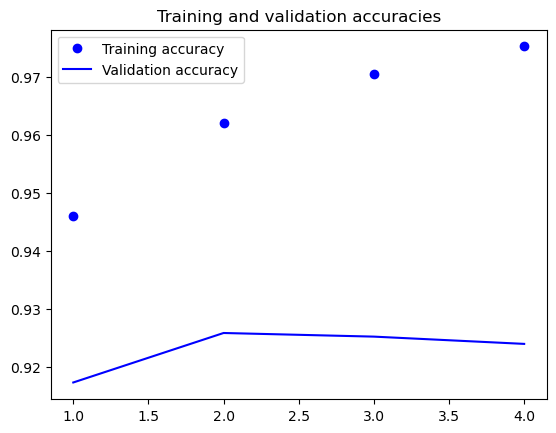

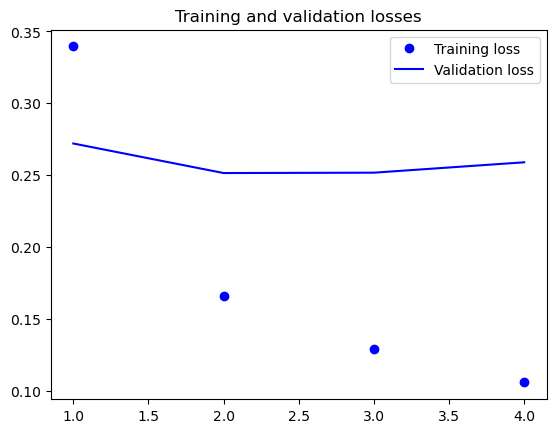

In [45]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

### Formatting the Test Set

In [46]:
X_test_dict, y_test_cat = context_dictorizer.transform(test_dict)
for x_test_dict in X_test_dict:
    for word in x_test_dict:
        x_test_dict[word] = word2idx.get(x_test_dict[word], 0)
            
# We transform the symbols into numbers
X_test = dict_vect.transform(X_test_dict)
y_test = torch.LongTensor([pos_idx.get(i, 0) for i in y_test_cat])

X_test = torch.from_numpy(X_test).long()

### Predicting a Value

In [47]:
Y_test_pred = model(X_test)
Y_test_pred

tensor([[-27.8314,  -7.5088, -10.6979,  ...,  -2.1553,  -6.0958,  -9.5026],
        [-22.9009,  -6.3113,  -2.3573,  ...,  -0.1835,  -3.7221, -15.0311],
        [-28.7046,  -8.3206,  -8.0756,  ...,  -1.6580,  -6.4537, -10.6366],
        ...,
        [-29.2281, -10.0862,   2.7727,  ...,  -8.4386,  -9.7233, -19.0596],
        [-35.2649,  -5.0239, -10.5849,  ...,   3.8192,  -4.2218, -18.1291],
        [-35.4783,  -7.8493,  -6.0712,  ...,  -9.7745,  -2.2910, -17.5126]],
       grad_fn=<AddmmBackward0>)

In [48]:
y_test_pred = torch.argmax(model(X_test), dim=-1)
y_test_pred

tensor([11, 14, 12,  ..., 10, 16, 13])

In [49]:
list(map(lambda x: idx2pos[x], torch.argmax(model(X_test), dim=-1).tolist()))

['PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'NOUN',
 'PUNCT',
 'PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'PRON',
 'NOUN',
 'PUNCT',
 'NOUN',
 'PUNCT',
 'CCONJ',
 'ADV',
 'NOUN',
 'PUNCT',
 'VERB',
 'ADP',
 'DET',
 'ADJ',
 'PUNCT',
 'ADJ',
 'NOUN',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'ADP',
 'PROPN',
 'VERB',
 'ADP',
 'PROPN',
 'PROPN',
 'PROPN',
 'PUNCT',
 'PUNCT',
 'CCONJ',
 'PUNCT',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'AUX',
 'PRON',
 'ADV',
 'ADV',
 'DET',
 'ADJ',
 'ADJ',
 'ADP',
 'DET',
 'NOUN',
 'SCONJ',
 'PRON',
 'AUX',
 'DET',
 'ADJ',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'DET',
 'NOUN',
 'VERB',
 'VERB',
 'SCONJ',
 '_',
 'PROPN',
 'PART',
 'VERB',
 'ADP',
 'NOUN',
 'AUX',
 'VERB',
 'PUNCT',
 'PRON',
 '_',
 'PRON',
 'AUX',
 'ADV',
 'VERB',
 'ADV',
 'PUNCT',
 'CCONJ',
 '_',
 'PRON',
 'AUX',
 'ADV',
 'ADV',
 'PUNCT',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'PROPN',
 'AUX',
 'DET',
 'ADJ',
 'NOUN',
 'NOUN',
 'PUNCT',
 'AUX',
 'PRON',
 'VERB',
 'PRON',
 'ADP',
 'PRON',
 'ADJ',
 'PUNCT

### Testing the Model

In [50]:
sum(torch.argmax(Y_test_pred, dim=-1) == y_test)/y_test.size()[0]

tensor(0.9271)

About 89.59 for the simple model and 90.31 for the second one

## Prediction of parts of speech

In [51]:
def predict_sentence(sentence, dict_vect, model, idx2pos):
    column_names = ['id', 'form']
    sentence = list(enumerate(sentence.lower().split(), start=1))
    conll_cols = ''
    for tuple in sentence:
        conll_cols += str(tuple[0]) + '\t' + tuple[1] + '\n'
    # print(conll_cols)

    conll_dict = CoNLLDictorizer(column_names, col_sep='\t')
    sent_dict = conll_dict.transform(conll_cols)
    #print('Sentence:', sent_dict[0])

    context_dictorizer = ContextDictorizer()
    context_dictorizer.fit(sent_dict)
    X_dict, y = context_dictorizer.transform(sent_dict, 
                                             training_step=False)
    # print('X_dict:', X_dict)
    # print('POS, y:', y)
    for x_dict in X_dict:
        for word in x_dict:
            x_dict[word] = word2idx.get(x_dict[word], 0)
    
    X = dict_vect.transform(X_dict)
    # print(X)
    X = torch.from_numpy(X).long()
    # print(X)
    y_prob = model(X)
    y_pred = torch.argmax(y_prob, dim=-1)
    y_pred_cat = [idx2pos[i.item()] for i in y_pred]
    return y_pred_cat

In [52]:
sentences = ["That round table might collapse .",
                 "The man can learn well .",
                 "The man can swim .",
                 "The man can simwo ."]
for sentence in sentences:
    y_test_pred_cat = predict_sentence(sentence.lower(), 
                                       dict_vect,
                                       model,
                                       idx2pos)
    print(sentence)
    print(y_test_pred_cat)

That round table might collapse .
['DET', 'DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'ADV', 'PUNCT']
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can simwo .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
